## import and read data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re


# Load the dataset
df = pd.read_csv('amazon.csv')



/var/folders/3h/r5l1t4656pbc6bzdv94m9wrm0000gn/T/ipykernel_7459/2672717053.py:9: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('amazon.csv')


In [2]:
# Display the first few rows of the dataframe
df.head()

# Display the concise summary of the DataFrame
# print("DataFrame Information:")
df.info()

# Display the shape of the DataFrame
print("\nDataFrame Shape:")
print(df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

## Some preprocessing and exploration

In [3]:
df_copy = df.copy()


In [4]:
# Dropping columns with predominantly missing values or not relevant
columns_to_drop = ['reviews.userCity', 'reviews.userProvince', 'reviews.didPurchase', 'reviews.id']
df_copy.drop(columns=columns_to_drop, inplace=True)

# Filling missing values in 'name' with "Unknown"
df_copy['name'].fillna('Unknown', inplace=True)


In [5]:
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string inputs
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df_copy['reviews.text'] = df_copy['reviews.text'].apply(clean_text)



In [6]:
df_copy['reviews.date'] = pd.to_datetime(df_copy['reviews.date'])


In [7]:
# Example: Filling missing ratings with the median rating
median_rating = df_copy['reviews.rating'].median()
df_copy['reviews.rating'].fillna(median_rating, inplace=True)
# df_copy

## Distribution of Review Ratings

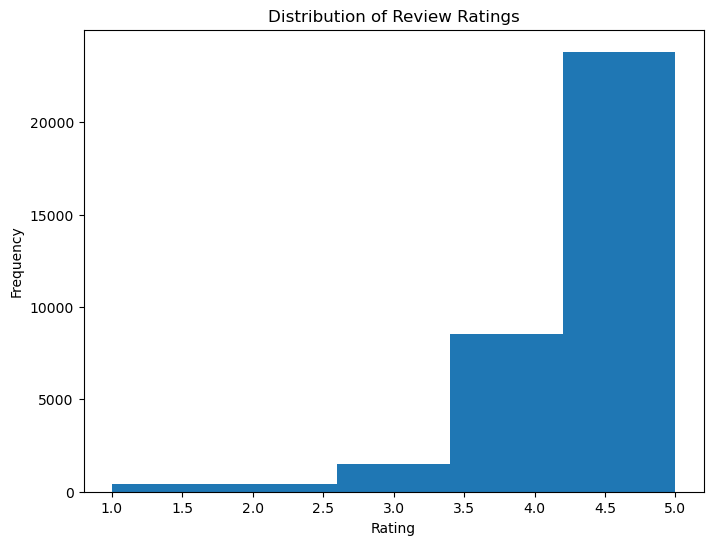

In [8]:
plt.figure(figsize=(8, 6))
df_copy['reviews.rating'].hist(bins=5, grid=False)
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


## Distribution of Sentiments

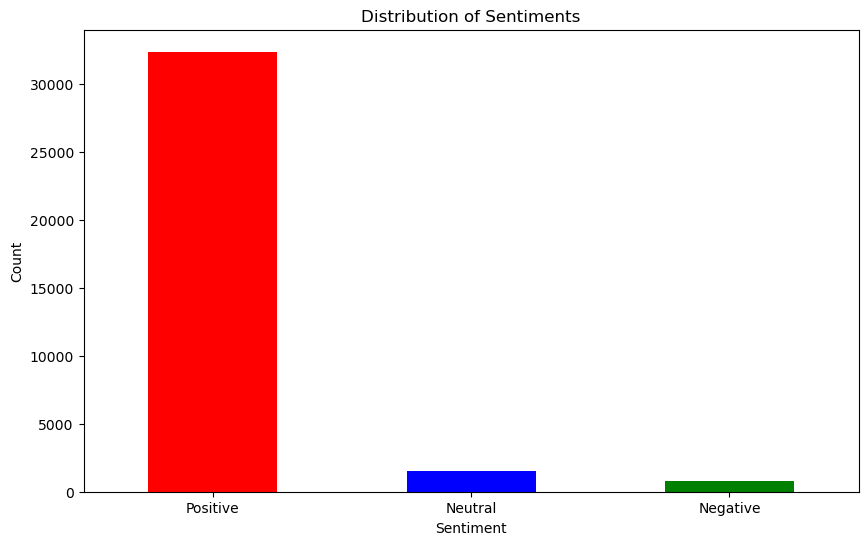

In [9]:
# This is an example. Adjust the categorization logic based on your actual dataset and analysis needs.
df_copy['sentiment_label'] = pd.cut(df_copy['reviews.rating'],
                                    bins=[0, 2, 3, 5],
                                    labels=['Negative', 'Neutral', 'Positive'],
                                    include_lowest=True)

# Now, let's plot the sentiment distribution.
sentiment_counts = df_copy['sentiment_label'].value_counts()

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


## Sentiment Over Time

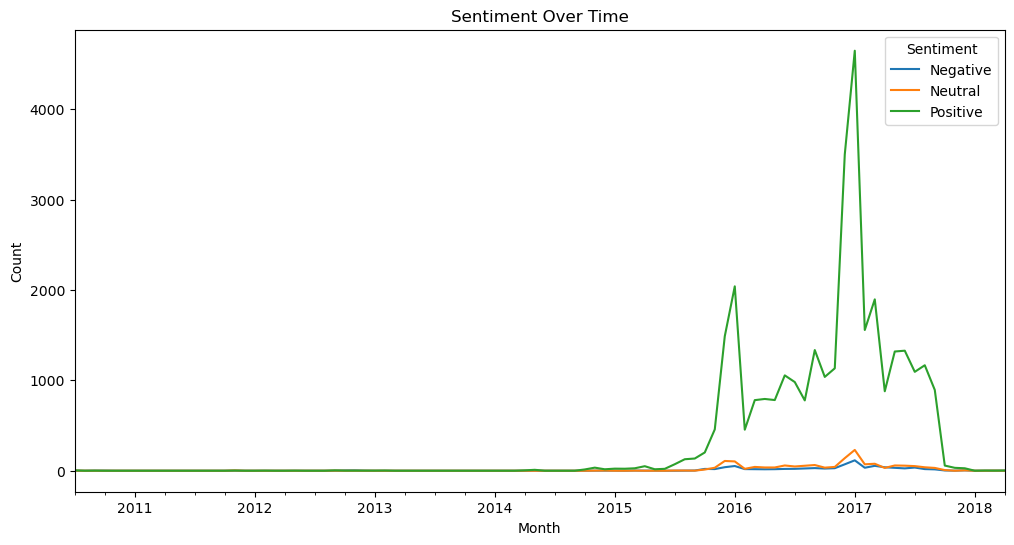

In [10]:
# First, ensure your 'reviews.date' is a datetime type and set it as the index.
df_copy['reviews.date'] = pd.to_datetime(df_copy['reviews.date'])
df_copy.set_index('reviews.date', inplace=True)

# Resample data monthly and count sentiment labels
monthly_sentiments = df_copy.resample('M')['sentiment_label'].value_counts().unstack().fillna(0)

# Plotting
monthly_sentiments.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()


## Word Cloud for Positive/Negative Sentiments

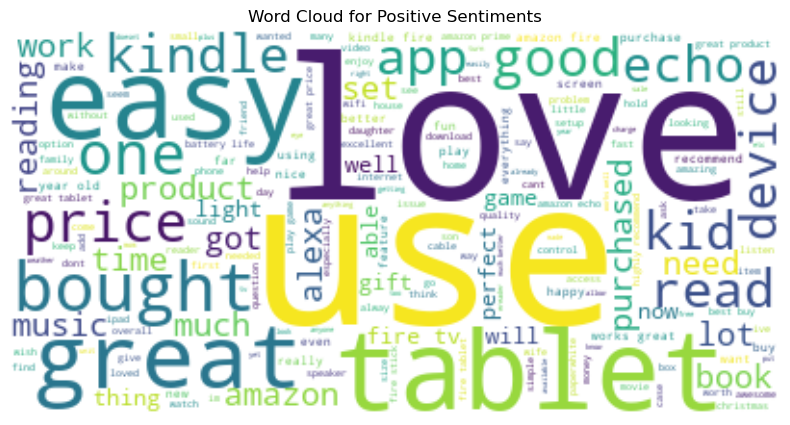

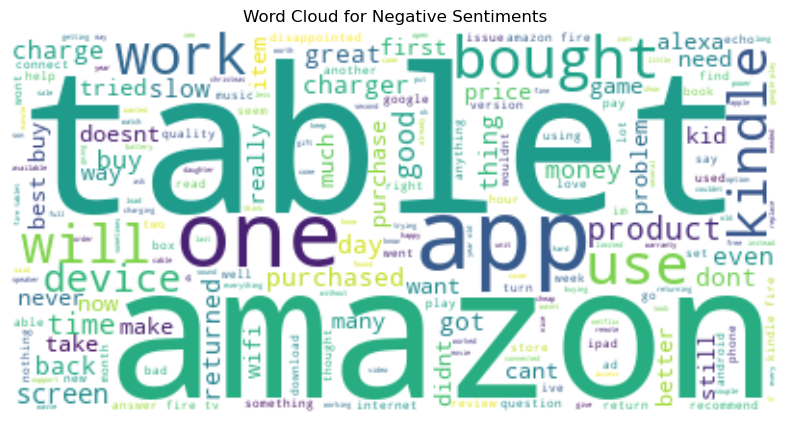

In [11]:
# Concatenate all reviews based on sentiment
positive_reviews = ' '.join(df_copy[df_copy['sentiment_label'] == 'Positive']['reviews.text'])
negative_reviews = ' '.join(df_copy[df_copy['sentiment_label'] == 'Negative']['reviews.text'])

# Generate a word cloud image for positive sentiments
wordcloud_pos = WordCloud(background_color="white").generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Sentiments')
plt.show()

# Generate a word cloud image for negative sentiments
wordcloud_neg = WordCloud(background_color="white").generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Sentiments')
plt.show()

## Top x Brands by Review Count

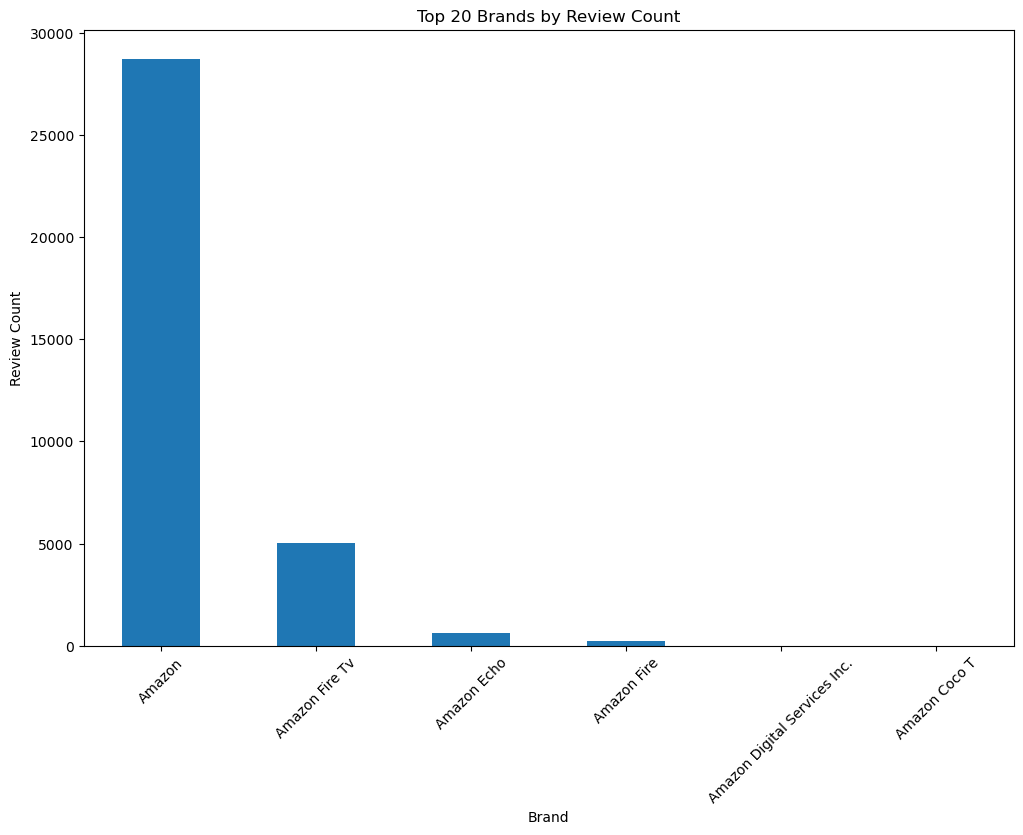

In [12]:
top_n = 20  # Adjust N based on your preference
brand_counts = df_copy['brand'].value_counts().head(top_n)

plt.figure(figsize=(12, 8))
brand_counts.plot(kind='bar')
plt.title('Top {} Brands by Review Count'.format(top_n))
plt.xlabel('Brand')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.show()


## Top x Categories by Review Count

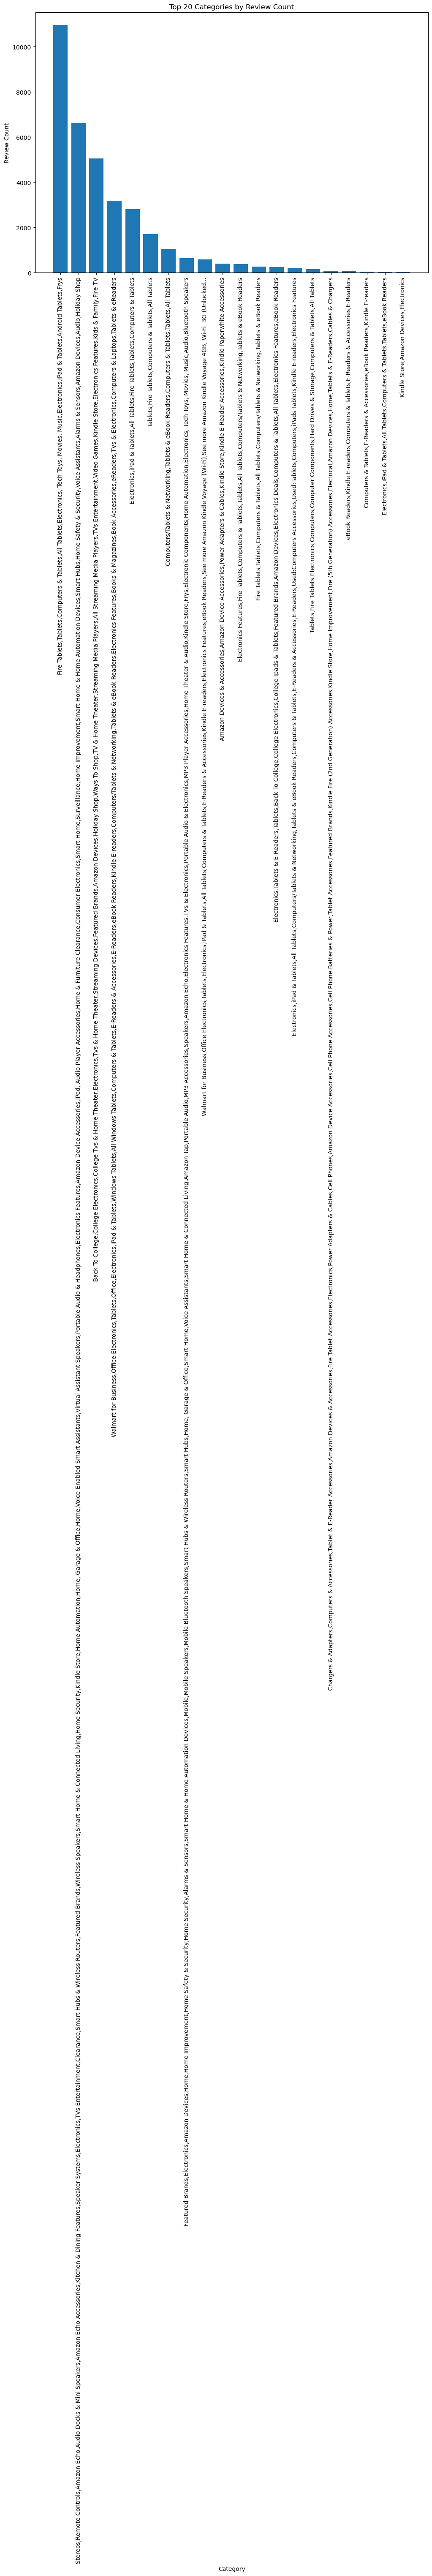

In [13]:
# Assuming categories are separated by a delimiter like ";". Adjust this based on your actual data format.
category_counts = Counter([category for sublist in df_copy['categories'].str.split(';').tolist() for category in sublist])
most_common_categories = dict(category_counts.most_common(top_n))

plt.figure(figsize=(12, 8))
plt.bar(most_common_categories.keys(), most_common_categories.values())
plt.title('Top {} Categories by Review Count'.format(top_n))
plt.xlabel('Category')
plt.ylabel('Review Count')
plt.xticks(rotation=90)  # Rotate labels to fit complex category names
plt.show()


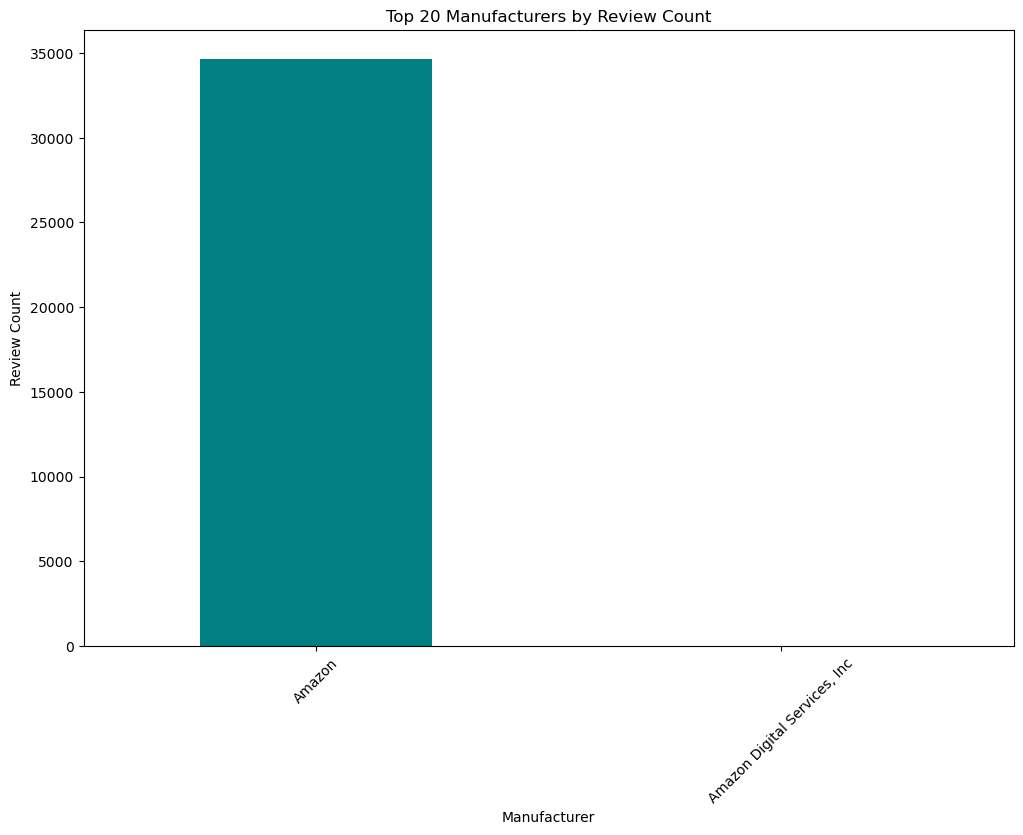

In [14]:
manufacturer_counts = df_copy['manufacturer'].value_counts().head(top_n)

plt.figure(figsize=(12, 8))
manufacturer_counts.plot(kind='bar', color='teal')
plt.title('Top {} Manufacturers by Review Count'.format(top_n))
plt.xlabel('Manufacturer')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.show()
